## Building Recommendation Functions

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Building Recommendation Functions (this notebook)

**In this notebook, you'll find:**
- Classification models using content-based filtering
- Brief analyses for each model

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from scipy import sparse, spatial
import sys
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, cosine_distances, pairwise_distances_argmin_min

from numpy import dot
from numpy.linalg import norm

In [7]:
conda install -c conda-forge scikit-surprise

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader

---
#### **Importing All-Feature Dataframe**

This is the aggregated dataframe of all of our datasets.

In [4]:
agg_df = pd.read_csv('../datasets/cleaned_data/all_features.csv')

agg_df.head()

,place,state,price,auto_accss_idx,pct_no_vehicle,pct_one_or_more_vehicles,transit_accss_idx,walkability_idx,cost_of_living,grocery_cost_idx,...,nov_avg_rain,dec_avg_rain,winter_avg_temp,spring_avg_temp,summer_avg_temp,autumn_avg_temp,winter_avg_rain,spring_avg_rain,summer_avg_rain,autumn_avg_rain
0,Asheville,NC,191.671287,0.580614,0.053756,0.946244,0.149850,9.382035,105.7,103.1,...,3.11,3.69,40.166667,53.333333,70.200000,55.333333,3.710000,4.160000,4.713333,3.423333
1,Austin,TX,280.389031,0.718323,0.059187,0.940813,0.286952,11.516379,129.4,96.7,...,2.52,2.42,53.400000,67.433333,82.333333,70.366667,2.243333,3.256667,2.386667,3.026667
2,Boston,MA,246.906229,0.759096,0.301252,0.698748,0.409262,14.936791,153.4,111.4,...,4.04,4.01,33.100000,49.700000,72.233333,56.000000,3.810000,3.790000,3.463333,3.703333
3,Cambridge,MA,246.035242,0.563985,0.102769,0.897231,0.160956,12.458517,173.7,115.5,...,4.00,3.85,31.100000,49.166667,71.633333,54.533333,3.570000,3.706667,3.523333,3.676667
4,Chicago,IL,235.391606,0.636256,0.169022,0.830978,0.310866,13.635529,107.4,97.2,...,2.44,2.04,28.133333,50.833333,73.933333,55.766667,1.760000,3.223333,3.643333,2.853333


In [8]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   place                     33 non-null     object 
 1   state                     33 non-null     object 
 2   price                     33 non-null     float64
 3   auto_accss_idx            33 non-null     float64
 4   pct_no_vehicle            33 non-null     float64
 5   pct_one_or_more_vehicles  33 non-null     float64
 6   transit_accss_idx         33 non-null     float64
 7   walkability_idx           33 non-null     float64
 8   cost_of_living            33 non-null     float64
 9   grocery_cost_idx          33 non-null     float64
 10  transportation_cost_idx   33 non-null     float64
 11  miscellaneous_cost_idx    33 non-null     float64
 12  population                33 non-null     int64  
 13  median_age                33 non-null     float64
 14  summer_comfo

In [9]:
agg_df['place'] = agg_df[['place', 'state']].apply(lambda x: ', '.join(x), axis=1)
agg_df.drop(columns='state', inplace=True)
agg_df.head()

,place,price,auto_accss_idx,pct_no_vehicle,pct_one_or_more_vehicles,transit_accss_idx,walkability_idx,cost_of_living,grocery_cost_idx,transportation_cost_idx,...,nov_avg_rain,dec_avg_rain,winter_avg_temp,spring_avg_temp,summer_avg_temp,autumn_avg_temp,winter_avg_rain,spring_avg_rain,summer_avg_rain,autumn_avg_rain
0,"Asheville, NC",191.671287,0.580614,0.053756,0.946244,0.149850,9.382035,105.7,103.1,82.8,...,3.11,3.69,40.166667,53.333333,70.200000,55.333333,3.710000,4.160000,4.713333,3.423333
1,"Austin, TX",280.389031,0.718323,0.059187,0.940813,0.286952,11.516379,129.4,96.7,109.9,...,2.52,2.42,53.400000,67.433333,82.333333,70.366667,2.243333,3.256667,2.386667,3.026667
2,"Boston, MA",246.906229,0.759096,0.301252,0.698748,0.409262,14.936791,153.4,111.4,131.8,...,4.04,4.01,33.100000,49.700000,72.233333,56.000000,3.810000,3.790000,3.463333,3.703333
3,"Cambridge, MA",246.035242,0.563985,0.102769,0.897231,0.160956,12.458517,173.7,115.5,95.7,...,4.00,3.85,31.100000,49.166667,71.633333,54.533333,3.570000,3.706667,3.523333,3.676667
4,"Chicago, IL",235.391606,0.636256,0.169022,0.830978,0.310866,13.635529,107.4,97.2,138.5,...,2.44,2.04,28.133333,50.833333,73.933333,55.766667,1.760000,3.223333,3.643333,2.853333


In [10]:
# Creating a dataframe with only the columns that include values we can request from the user
rec_model_df = agg_df[['place', 'winter_avg_temp', 'summer_avg_temp', 'chain_ratio', 'walkability_idx', 'political_left_lean', 'political_right_lean', 'miscellaneous_cost_idx', 'price']]

In [11]:
# Converting price column to monthly cost with Airbnb's estimated 30-day stay discount
rec_model_df['avg_monthly_price'] = (rec_model_df['price'] * 30) - ((rec_model_df['price'] * 30) * 0.25)
rec_model_df.drop(columns=['price'], inplace=True)
rec_model_df.head()

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_1443/1281049182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_model_df['avg_monthly_price'] = (rec_model_df['price'] * 30) - ((rec_model_df['price'] * 30) * 0.25)
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_1443/1281049182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_model_df.drop(columns=['price'], inplace=True)


,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.3516,9.382035,0.597,0.386,111.2,4312.603960
1,"Austin, TX",53.400000,82.333333,0.3814,11.516379,0.714,0.264,105.9,6308.753191
2,"Boston, MA",33.100000,72.233333,0.2796,14.936791,0.806,0.175,157.9,5555.390144
3,"Cambridge, MA",31.100000,71.633333,0.3277,12.458517,0.715,0.263,176.7,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.3717,13.635529,0.742,0.240,139.8,5296.311131


In [67]:
rec_model_df.to_csv('../streamlit/location_features_df.csv', index=False)

---
#### **Building Functions to Recommend a Location Based on User Input**

In [60]:
def wfh_input_converter(user_input_data, df):

    '''Inserting placeholder for location name'''
    user_input_data.insert(0, 'User Input')

    '''Converting user list to dictionary'''
    feat_keys = ['place', 'low_temp', 'high_temp', 'chain_pref', 'walk_pref', 'pol_dem_pref', 'misc_costs', 'monthly_budget']
    user_input_dict = dict(zip(feat_keys, user_input_data))

    '''Creating indices for ordinal input values'''
    # Chain preferences
    chain_mean = df['chain_ratio'].mean()
    chain_std = df['chain_ratio'].std()

    chain_input_options = ['I only eat at Mom-n-Pop restaurants', 'I prefer non-chain restaurants', 'I like a combination of both', 'I would rather go somewhere that has a drive-thru', 'The faster the food the better']
    chain_input_index = [chain_mean - (2*chain_std), chain_mean - (1*chain_std), chain_mean, chain_mean + (1*chain_std), chain_mean + (2*chain_std)]
    chain_mapper = dict(zip(chain_input_options, chain_input_index))
    
    # Walkability preferences
    walk_mean = df['walkability_idx'].mean()
    walk_std = df['walkability_idx'].std()

    walk_input_options = ['Not important at all', 'Not very important', 'Neutral', 'A little important', 'Very important']
    walk_input_index = [walk_mean - (2*walk_std), walk_mean - (1*walk_std), walk_mean, walk_mean + (1*walk_std), walk_mean + (2*walk_std)]
    walkability_mapper = dict(zip(walk_input_options, walk_input_index))

    # Political lean preferences
    # Using the mean here instead of 50/50 because most locations have a slight to moderate left lean, meaning that if we set the default value to 0.5, we'd be unintentionally biasing the results
    pol_mean = df['political_left_lean'].mean()
    pol_std = df['political_left_lean'].std()

    pol_pref_options = ['Strong left lean preferred', 'Moderate left lean preferred', 'Moderate right lean preferred', 'Strong right lean preferred']
    pol_pref_index = [pol_mean + (2*pol_std), pol_mean + (1*pol_std), pol_mean - (1*pol_std), pol_mean - (2*pol_std)]
    pol_pref_mapper = dict(zip(pol_pref_options, pol_pref_index))

    '''Mapping user-provided preferences to defined numerical value'''
    # Chain preferences
    for k, v in chain_mapper.items():
        if user_input_dict['chain_pref'] == k:
            user_input_dict['chain_pref'] = v

    # Walkability preferences
    for k, v in walkability_mapper.items():
        if user_input_dict['walk_pref'] == k:
            user_input_dict['walk_pref'] = v

    # Political lean preferences
    for k, v in pol_pref_mapper.items():
        if user_input_dict['pol_dem_pref'] == k:
            user_input_dict['pol_dem_pref'] = v
        else:
            user_input_dict['pol_dem_pref'] = pol_mean
    
    pol_rep_pref = 1 - user_input_dict['pol_dem_pref']

    '''Estimating miscellaneous cost index based on user input'''
    misc_mean = df['miscellaneous_cost_idx'].mean()
    misc_std = df['miscellaneous_cost_idx'].std()

    user_input_dict['misc_costs'] = misc_mean + (user_input_dict['misc_costs'] * misc_std/5)

    '''Converting dictionary values to list'''
    user_input_list = list(user_input_dict.values())

    '''Inserting the Repulican-lean political value into our user list'''
    user_input_list.insert(6, pol_rep_pref)

    '''Adding the updated list as a new row in our dataframe'''
    df.loc[len(df)] = user_input_list
    
    return user_input_list

The above is the first function that will convert each of the necessary user preferences values/strings into usable data. Now, we'll need to create a function that can take in the full dataframe and find the location that is most similar to the user-defined row.

In [61]:
def find_rec(df, input_row = 'User Input'): # Defining the input row here because we will always be evaluating/recommending for the 'User Input' row

    '''Scaling all numeric columns'''
    feature_cols = df.columns[1:]
    minmax = MinMaxScaler()
    scaled_df = minmax.fit_transform(df[feature_cols])

    '''Setting all place indices for reference'''
    indices = pd.Series(df.index, index=df['place'])
    user_index = indices[input_row]

    '''Finding the cosine similarities between all location vectors'''
    cosine_sim = cosine_similarity(scaled_df)

    '''Filtering and sorting the cosine similarity values for input data'''
    sim_scores = list(enumerate(cosine_sim[user_index]))
    sim_scores_sorted = sorted(sim_scores, key = lambda x:x[1], reverse=True)

    '''Finding and returning the location most similar to user's preferences'''
    best_fit_score = sim_scores_sorted[1]
    best_fit_index = best_fit_score[0]
    recommended_place = df['place'].iloc[best_fit_index]

    return f'You should go to: {recommended_place}!'

Now that we have our two functions, if we run an example user through both, we should have a location recommendation output.

In [62]:
ex_user_1 = [65, 75, 'I prefer non-chain restaurants', 'Neutral', 'Moderate left lean preferred', 5, 6000]

In [64]:
wfh_input_converter(ex_user_1, rec_model_df)

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_1443/470807313.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[len(df)] = user_input_list


['User Input',
 65,
 75,
 0.22781856884367263,
 12.075446543882068,
 0.7012000000000002,
 0.29879999999999984,
 154.74250341119108,
 6000]

In [65]:
find_rec(rec_model_df)

'You should go to: San Diego, CA!'

In [66]:
rec_model_df

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,4312.603960
1,"Austin, TX",53.400000,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,6308.753191
2,"Boston, MA",33.100000,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,5555.390144
3,"Cambridge, MA",31.100000,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5296.311131
5,"Columbus, OH",32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3873.294872
6,"Dallas, TX",49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,3967.300242
7,"Denver, CO",33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4264.297859
8,"Fort Lauderdale, FL",70.300000,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5109.527675
9,"Fort Worth, TX",49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,3965.832342


In [32]:
if 'User Input' in rec_model_df['place'].unique():
    print(True)

True


In [33]:
for i in range(10):
    if f'User Input_{i}' in rec_model_df['place'].unique():
        print(True)

In [21]:
# trial_model_df.to_csv('../streamlit/test_df.csv', index=False)

In [189]:
def wfh(user_input_data):
    '''Inserting placeholder for location name'''
    user_input_data.insert(0, 'User Input')

    '''Converting user list to dictionary'''
    feat_keys = ['place', 'low_temp', 'high_temp', 'food_pref', 'walk_pref', 'pol_dem_pref', 'misc_costs', 'monthly_budget']
    user_input_dict = dict(zip(feat_keys, user_input_data))

    '''Creating indices for ordinal input values'''

    # Food preferences
    chain_mean = trial_model_df['chain_ratio'].mean()
    chain_std = trial_model_df['chain_ratio'].std()

    chain_input_options = ['I only eat at Mom-n-Pop restaurants', 'I prefer non-chain restaurants', 'I like a combination of both', 'I would rather go somewhere that has a drive-thru', 'The faster the food the better']
    chain_input_index = [chain_mean - (2*chain_std), chain_mean - (1*chain_std), chain_mean, chain_mean + (1*chain_std), chain_mean + (2*chain_std)]
    chain_mapper = dict(zip(chain_input_options, chain_input_index))
    
    # Walkability
    walk_mean = trial_model_df['walkability_idx'].mean()
    walk_std = trial_model_df['walkability_idx'].std()

    walk_input_options = ['Not important at all', 'Not very important', 'Neutral', 'A little important', 'Very important']
    walk_input_index = [walk_mean - (2*walk_std), walk_mean - (1*walk_std), walk_mean, walk_mean + (1*walk_std), walk_mean + (2*walk_std)]
    walkability_mapper = dict(zip(walk_input_options, walk_input_index))

    # Political lean preferences
    # Using the mean here instead of 50/50 because most locations have a slight to moderate left lean, meaning that if we set the default value to 0.5, we'd be unintentionally biasing the results
    pol_mean = trial_model_df['political_left_lean'].mean()
    pol_std = trial_model_df['political_left_lean'].std()

    pol_pref_options = ['Strong left lean preferred', 'Moderate left lean preferred', 'Moderate right lean preferred', 'Strong right lean preferred']
    pol_pref_index = [pol_mean + (2*pol_std), pol_mean + (1*pol_std), pol_mean - (1*pol_std), pol_mean - (2*pol_std)]
    pol_pref_mapper = dict(zip(pol_pref_options, pol_pref_index))

    '''Mapping food preference to numerical value'''
    for k, v in chain_mapper.items():
        if user_input_dict['food_pref'] == k:
            user_input_dict['food_pref'] = v

    '''Mapping walkability preference to numerical value'''
    for k, v in walkability_mapper.items():
        if user_input_dict['walk_pref'] == k:
            user_input_dict['walk_pref'] = v

    '''Mapping political preference to numerical value'''
    for k, v in pol_pref_mapper.items():
        if user_input_dict['pol_dem_pref'] == k:
            user_input_dict['pol_dem_pref'] = v
        else:
            user_input_dict['pol_dem_pref'] = pol_mean
    
    pol_rep_pref = 1 - user_input_dict['pol_dem_pref']

    '''Estimating miscellaneous cost index based on user input'''
    misc_mean = trial_model_df['miscellaneous_cost_idx'].mean()
    misc_std = trial_model_df['miscellaneous_cost_idx'].std()

    user_input_dict['misc_costs'] = misc_mean + (user_input_dict['misc_costs'] * misc_std/5)

    '''Converting dictionary values to list'''
    user_input_list = list(user_input_dict.values())

    '''Adding a Repulican-lean political value'''
    user_input_list.insert(6, pol_rep_pref)

    '''Adding the updated list as a new row in our dataframe'''
    trial_model_df.loc[len(trial_model_df)] = user_input_list
    
    return user_input_list

In [190]:
user_input_new = wfh(user_input)

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/73214471.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_model_df.loc[len(trial_model_df)] = user_input_list


In [26]:
date_str = '2023-01-01&'

print(date_str[5:7])

01


In [30]:
season_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

# for k, v in season_dict.items():
if diff <= 3:
    print(season_dict[trip_dates])

Winter


In [172]:
# Scaling all numeric columns
feature_cols = trial_model_df.columns[1:]
sc = MinMaxScaler()
scaled_df = sc.fit_transform(trial_model_df[feature_cols])

# Setting model and indices for reference
indices = pd.Series(trial_model_df.index, index=trial_model_df['place'])
cs_df = cosine_similarity(scaled_df)

In [173]:
def find_rec(input_row = 'User Input', model = cs_df):

    '''Indexing the user input row'''
    index = indices[input_row]

    '''Filtering and sorting the cosine similarity values for input data'''
    sim_scores = list(enumerate(model[index]))
    sim_scores_sorted = sorted(sim_scores, key = lambda x:x[1], reverse=True)

    '''Finding and returning the location most similar to user's preferences'''
    best_fit_score = sim_scores_sorted[1]
    best_fit_index = best_fit_score[0]
    recommended_place = trial_model_df['place'].iloc[best_fit_index]

    return f'You should go to: {recommended_place}!'

In [ ]:
trial_model_df.iloc[1]['avg_monthly_price']

9816.145584725538

In [ ]:
cs_df[33]

array([0.85100936, 0.86068596, 0.89646015, 0.90605552, 0.88156583,
       0.77336091, 0.84213213, 0.89275666, 0.89697403, 0.73681875,
       0.80636906, 0.88149077, 0.75397283, 0.80792062, 0.94371327,
       0.73909004, 0.82931122, 0.83609589, 0.94488851, 0.86343604,
       0.9479034 , 0.93593383, 0.88500789, 0.86587869, 0.71886936,
       0.94976773, 0.86161206, 0.90994135, 0.94569342, 0.926109  ,
       0.88057069, 0.79821859, 0.85312821, 1.        ])

In [ ]:
trial_model_df.iloc[:, 1:]

,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,5081.183654
1,53.400000,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,9816.145585
2,33.100000,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,6139.778716
3,31.100000,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5532.853672
5,32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3835.510118
6,49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,5658.053279
7,33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4313.462492
8,70.300000,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5663.896761
9,49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,4079.534543


In [ ]:
trial_model_df

,place,winter_avg_temp,summer_avg_temp,walkability_idx,chain_ratio,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,9.382035,0.351600,0.5970,0.3860,111.200000,5081.183654
1,"Austin, TX",53.400000,82.333333,11.516379,0.381400,0.7140,0.2640,105.900000,9816.145585
2,"Boston, MA",33.100000,72.233333,14.936791,0.279600,0.8060,0.1750,157.900000,6139.778716
3,"Cambridge, MA",31.100000,71.633333,12.458517,0.327700,0.7150,0.2630,176.700000,5535.792952
4,"Chicago, IL",28.133333,73.933333,13.635529,0.371700,0.7420,0.2400,139.800000,5532.853672
5,"Columbus, OH",32.866667,74.100000,11.556746,0.501200,0.6470,0.3340,107.500000,3835.510118
6,"Dallas, TX",49.566667,82.666667,11.899341,0.478300,0.6490,0.3330,107.800000,5658.053279
7,"Denver, CO",33.166667,73.466667,14.462231,0.327400,0.7960,0.1820,152.200000,4313.462492
8,"Fort Lauderdale, FL",70.300000,82.533333,12.445745,0.383700,0.6450,0.3470,107.600000,5663.896761
9,"Fort Worth, TX",49.166667,82.133333,9.585953,0.559500,0.4930,0.4910,109.200000,4079.534543


In [ ]:
user_input

[65,
 75,
 'I like to try new restaurants',
 'Neutral',
 'Moderate left lean preferred',
 5,
 6000]

In [ ]:
test_dict = {'place': 'User Input', 'low_temp': 65, 'high_temp': 75, 'food_pref': 'I like to try new restaurants', 'walk_pref': 'Neutral', 'pol_pref': 'Moderate left lean preferred', 'misc_costs': 5, 'monthly_budget': 6000}

In [ ]:
list(test_dict.values())

['User Input',
 65,
 75,
 'I like to try new restaurants',
 'Neutral',
 'Moderate left lean preferred',
 5,
 6000]

In [ ]:
print(test_dict['food_pref'])

I like to try new restaurants


In [ ]:
user_input

['User Input',
 65,
 75,
 'I like to try new restaurants',
 'Neutral',
 'Moderate left lean preferred',
 5,
 6000]

In [ ]:
user_input.insert(0, 'User Input')

In [ ]:
user_input

['User Input', 65, 75, 12.07544654388207, 0.25, 0.8, 0.2, 155, 6000]

In [ ]:
walk_mean = trial_model_df['walkability_idx'].mean()
walk_std = trial_model_df['walkability_idx'].std()

In [ ]:
walk_input_options = ['Not important at all', 'Not very important', 'Neutral', 'A little important', 'Very important']

In [ ]:
walk_input_index = [walk_mean - (2*walk_std), walk_mean - (1*walk_std), walk_mean, walk_mean + (1*walk_std), walk_mean + (2*walk_std)]

In [ ]:
walk_input_index

[7.077144672571502,
 9.576295608226786,
 12.07544654388207,
 14.574597479537353,
 17.073748415192636]

In [ ]:
walkability_mapper = list(zip(walk_input_options, walk_input_index))
walkability_mapper

[('Not important at all', 7.077144672571502),
 ('Not very important', 9.576295608226786),
 ('Neutral', 12.07544654388207),
 ('A little important', 14.574597479537353),
 ('Very important', 17.073748415192636)]

In [ ]:
trial_model_df.describe()

,winter_avg_temp,summer_avg_temp,walkability_idx,chain_ratio,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,46.471082,74.791385,12.075447,0.328676,0.701200,0.277730,129.344848,6387.315367
std,14.479006,6.471081,2.499151,0.100857,0.100124,0.100504,25.397655,2347.730358
min,17.985714,62.200000,4.986450,0.113600,0.489000,0.054000,92.900000,3437.974960
25%,35.533333,70.900000,11.519265,0.284800,0.645000,0.202000,107.600000,4606.418306
50%,47.033333,75.133333,12.445745,0.313500,0.714000,0.266500,124.000000,5663.896761
75%,51.333333,80.166667,13.635529,0.383700,0.779000,0.346000,152.900000,7618.616379
max,78.333333,87.200000,15.957258,0.559500,0.921000,0.491000,176.700000,14795.287657


In [ ]:
user_input = ['User Input', 65, 75, 'I like to try new restaurants', 'Neutral', 'Moderate left lean preferred', 5, 6000]

# can we turn this into a dictionary?

In [ ]:
user_input[5]

'Moderate left lean preferred'

In [ ]:
for i in walkability_mapper:
    print(i[0])

Not important at all
Not very important
Neutral
A little important
Very important


In [ ]:
pol_pref_options = ['Strong left lean preferred', 'Moderate left lean preferred', 'Moderate right lean preferred', 'Strong right lean preferred']
pol_pref_nums = [.9, .8, .6, .5]

pol_dem_mapper = list(zip(pol_pref_options, pol_pref_nums))
pol_dem_mapper

[('Strong left lean preferred', 0.9),
 ('Moderate left lean preferred', 0.8),
 ('Moderate right lean preferred', 0.6),
 ('Strong right lean preferred', 0.5)]

In [ ]:
trial_model_df['chain_ratio'].std()

0.10085718873208491

In [ ]:
[i[1] for i in pol_dem_mapper if user_input[5] == i[0]] 

[0.8]

In [ ]:
for i in walkability_mapper:
    if user_input[4] == i[0]:
        print(i[1])
        user_walk_index = i[1]

12.07544654388207


In [ ]:
if user_input[5] == 'No':
    user_pol_dem = .7
else:
    user_pol_dem = [i[1] for i in pol_dem_mapper if user_input[5] == i[0]]   

print(user_pol_dem[0])

0.8


In [ ]:
user_input = ['User Input', 65, 75, 12.07544654388207, 0.25, 0.8, 0.2, 155, 6000]

In [ ]:
len(user_input)

9

In [ ]:
user_input_2 = ['User Input_2', 70, 80, 12.07544654388207, 0.30, 0.7, 0.3, 140, 6000]

In [ ]:
user_input_3 = ['User Input_3', 65, 75, 0.2, 14.574597479537353, 0.85, 0.15, 135, 5500]

In [ ]:
trial_model_df.loc[len(trial_model_df)] = user_input_3

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_1861/1424498399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_model_df.loc[len(trial_model_df)] = user_input_3


In [ ]:
trial_model_df.describe()

,winter_avg_temp,summer_avg_temp,walkability_idx,chain_ratio,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,47.016050,74.797521,12.148951,0.324891,0.705576,0.273974,129.511176,6361.217857
std,14.607755,6.372381,2.498037,0.101739,0.101844,0.101364,25.028679,2316.887820
min,17.985714,62.200000,4.986450,0.113600,0.489000,0.054000,92.900000,3437.974960
25%,35.883333,71.083333,11.528635,0.280900,0.645000,0.189250,107.650000,4636.817211
50%,47.733333,75.066667,12.452131,0.313150,0.714500,0.265250,128.600000,5660.975020
75%,52.508333,79.616667,13.757222,0.383125,0.782750,0.343000,152.725000,7490.267552
max,78.333333,87.200000,15.957258,0.559500,0.921000,0.491000,176.700000,14795.287657


In [160]:
trial_model_df.drop([33, 34], axis=0, inplace=True)

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/2706809782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_model_df.drop([33, 34], axis=0, inplace=True)


In [ ]:
user_input_3 = ['User Input_3', 65, 75, 0.2, 14.574597479537353, 0.85, 0.15, 135, 5500]

In [ ]:
test = model_df[['place', 'price', 'pct_no_vehicle', 'cost_of_living', 'walkability_idx', 'chain_ratio']]

In [146]:
trial_model_df.columns[1:]

Index(['winter_avg_temp', 'summer_avg_temp', 'chain_ratio', 'walkability_idx',
       'political_left_lean', 'political_right_lean', 'miscellaneous_cost_idx',
       'avg_monthly_price'],
      dtype='object')

In [151]:
user_input_3

['User Input_3', 65, 75, 14.574597479537353, 0.2, 0.85, 0.15, 135, 5500]

In [191]:
trial_model_df

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,4312.603960
1,"Austin, TX",53.4,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,6308.753191
2,"Boston, MA",33.1,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,5555.390144
3,"Cambridge, MA",31.1,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5296.311131
5,"Columbus, OH",32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3873.294872
6,"Dallas, TX",49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,3967.300242
7,"Denver, CO",33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4264.297859
8,"Fort Lauderdale, FL",70.3,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5109.527675
9,"Fort Worth, TX",49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,3965.832342


In [ ]:
user_input_3 = ['User Input_3', 65, 75, 0.2, 14.574597479537353, 0.85, 0.15, 135, 5500]

In [175]:
user_input_new

['User Input',
 65,
 75,
 0.22489713623006752,
 12.07544654388207,
 0.7012000000000002,
 0.29879999999999984,
 155.47817271095712,
 6000]

In [186]:
trial_model_df.drop(34, axis = 0, inplace=True)

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/544013590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_model_df.drop(34, axis = 0, inplace=True)


In [192]:
feature_cols = trial_model_df.columns[1:]

sc = MinMaxScaler()
scaled_trial = sc.fit_transform(trial_model_df[feature_cols])

print(scaled_trial[:2])

[[0.36755307 0.32       0.53375196 0.40066191 0.25       0.7597254
  0.21837709 0.1439967 ]
 [0.58683816 0.80533333 0.60058309 0.59520954 0.52083333 0.4805492
  0.15513126 0.47360877]]


In [193]:
indices = pd.Series(trial_model_df.index, index=trial_model_df['place'])

cosine = cosine_similarity(scaled_trial)

def place_recommender(place_name, model=cosine):
    index = indices[place_name]

    scores = list(enumerate(model[index]))

    sim_scores = sorted(scores, key= lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    top_recs_index = [i[0] for i in sim_scores]

    top_places = trial_model_df['place'].iloc[top_recs_index]

    return top_places

In [194]:
print('Recommended Places:')
print(place_recommender('User Input', cosine).values)

Recommended Places:
['San Diego, CA' 'Oahu, HI' 'Los Angeles, CA' 'New York City, NY'
 'Santa Clara, CA' 'Oakland, CA' 'Santa Cruz, CA' 'San Mateo, CA'
 'Cambridge, MA' 'Boston, MA']


In [187]:
trial_model_df

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.3516,9.382035,0.5970,0.3860,111.20,4312.603960
1,"Austin, TX",53.4,82.333333,0.3814,11.516379,0.7140,0.2640,105.90,6308.753191
2,"Boston, MA",33.1,72.233333,0.2796,14.936791,0.8060,0.1750,157.90,5555.390144
3,"Cambridge, MA",31.1,71.633333,0.3277,12.458517,0.7150,0.2630,176.70,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.3717,13.635529,0.7420,0.2400,139.80,5296.311131
5,"Columbus, OH",32.866667,74.100000,0.5012,11.556746,0.6470,0.3340,107.50,3873.294872
6,"Dallas, TX",49.566667,82.666667,0.4783,11.899341,0.6490,0.3330,107.80,3967.300242
7,"Denver, CO",33.166667,73.466667,0.3274,14.462231,0.7960,0.1820,152.20,4264.297859
8,"Fort Lauderdale, FL",70.3,82.533333,0.3837,12.445745,0.6450,0.3470,107.60,5109.527675
9,"Fort Worth, TX",49.166667,82.133333,0.5595,9.585953,0.4930,0.4910,109.20,3965.832342


In [ ]:
similarity_scores = sorted(list(enumerate(cosine[indices['San Francisco, CA']])), key= lambda x:x[1], reverse=True)

In [ ]:
[i[0] for i in similarity_scores]

[26,
 29,
 22,
 21,
 30,
 2,
 33,
 27,
 32,
 7,
 28,
 3,
 18,
 4,
 14,
 19,
 11,
 25,
 17,
 31,
 23,
 20,
 1,
 8,
 0,
 6,
 16,
 5,
 10,
 24,
 13,
 15,
 12,
 9]

In [ ]:
test['place'].iloc[[i[0] for i in similarity_scores]]

IndexError: positional indexers are out-of-bounds

In [ ]:
list(enumerate(cosine[indices['San Francisco, CA']]))

[(0, 0.6193912742600769),
 (1, 0.6663204108168225),
 (2, 0.9357412021223088),
 (3, 0.8657516959803817),
 (4, 0.8395501792898792),
 (5, 0.5982463256055518),
 (6, 0.6021465000932469),
 (7, 0.9031081772719182),
 (8, 0.6470090012206144),
 (9, 0.39795593080947744),
 (10, 0.508528500018575),
 (11, 0.8026399584354277),
 (12, 0.4351730226961039),
 (13, 0.4970843593989582),
 (14, 0.8213301133178844),
 (15, 0.48973877309779135),
 (16, 0.5999687496506284),
 (17, 0.7483638945425544),
 (18, 0.8631268510337504),
 (19, 0.8089178836193812),
 (20, 0.7030865468392643),
 (21, 0.9416791504997746),
 (22, 0.9422408807616666),
 (23, 0.7171311974160652),
 (24, 0.5064231347577338),
 (25, 0.755175841221089),
 (26, 1.0000000000000002),
 (27, 0.9174870444316416),
 (28, 0.8899594919509353),
 (29, 0.9448331426029035),
 (30, 0.938926867318185),
 (31, 0.7249665443563678),
 (32, 0.905169599864383),
 (33, 0.9184636375596953)]

In [ ]:
indices

place
Asheville, NC           0
Austin, TX              1
Boston, MA              2
Cambridge, MA           3
Chicago, IL             4
Columbus, OH            5
Dallas, TX              6
Denver, CO              7
Fort Lauderdale, FL     8
Fort Worth, TX          9
Hawaii, HI             10
Jersey City, NJ        11
Kauai, HI              12
Las Vegas, NV          13
Los Angeles, CA        14
Maui, HI               15
Nashville, TN          16
New Orleans, LA        17
New York City, NY      18
Newark, NJ             19
Oahu, HI               20
Oakland, CA            21
Portland, OR           22
Rhode Island, RI       23
Salem, OR              24
San Diego, CA          25
San Francisco, CA      26
San Mateo, CA          27
Santa Clara, CA        28
Santa Cruz, CA         29
Seattle, WA            30
Twin Cities, MN        31
Washington DC, DC      32
User Input_3           33
dtype: int64

In [ ]:
cosine_distances(model_df.iloc[:, 2:])

array([[0.00000000e+00, 4.29554703e-06, 3.87045136e-06, ...,
        4.06008214e-06, 4.11825903e-06, 3.83185116e-06],
       [4.29554703e-06, 0.00000000e+00, 1.85363105e-08, ...,
        1.21248582e-08, 8.32707103e-09, 1.91021039e-08],
       [3.87045136e-06, 1.85363105e-08, 0.00000000e+00, ...,
        3.12543202e-09, 6.59206745e-09, 3.81653376e-10],
       ...,
       [4.06008214e-06, 1.21248582e-08, 3.12543202e-09, ...,
        0.00000000e+00, 5.97219252e-09, 4.69485928e-09],
       [4.11825903e-06, 8.32707103e-09, 6.59206745e-09, ...,
        5.97219252e-09, 0.00000000e+00, 7.30497374e-09],
       [3.83185116e-06, 1.91021039e-08, 3.81653376e-10, ...,
        4.69485928e-09, 7.30497374e-09, 0.00000000e+00]])

In [ ]:
pairwise_distances(model_df.iloc[:, 2:], metric='cosine')

array([[4.44089210e-16, 4.29554703e-06, 3.87045136e-06, ...,
        4.06008214e-06, 4.11825903e-06, 3.83185116e-06],
       [4.29554703e-06, 4.44089210e-16, 1.85363105e-08, ...,
        1.21248582e-08, 8.32707103e-09, 1.91021039e-08],
       [3.87045136e-06, 1.85363105e-08, 0.00000000e+00, ...,
        3.12543202e-09, 6.59206745e-09, 3.81653376e-10],
       ...,
       [4.06008214e-06, 1.21248582e-08, 3.12543202e-09, ...,
        5.55111512e-16, 5.97219252e-09, 4.69485928e-09],
       [4.11825903e-06, 8.32707103e-09, 6.59206745e-09, ...,
        5.97219252e-09, 0.00000000e+00, 7.30497374e-09],
       [3.83185116e-06, 1.91021038e-08, 3.81653376e-10, ...,
        4.69485939e-09, 7.30497351e-09, 0.00000000e+00]])

In [ ]:
similarity_matrix= cosine_similarity(model_df.iloc[:, 2:])

sys.getsizeof(similarity_matrix)

8840

In [ ]:
similarity_matrix

array([[1.        , 0.9999957 , 0.99999613, ..., 0.99999594, 0.99999588,
        0.99999617],
       [0.9999957 , 1.        , 0.99999998, ..., 0.99999999, 0.99999999,
        0.99999998],
       [0.99999613, 0.99999998, 1.        , ..., 1.        , 0.99999999,
        1.        ],
       ...,
       [0.99999594, 0.99999999, 1.        , ..., 1.        , 0.99999999,
        1.        ],
       [0.99999588, 0.99999999, 0.99999999, ..., 0.99999999, 1.        ,
        0.99999999],
       [0.99999617, 0.99999998, 1.        , ..., 1.        , 0.99999999,
        1.        ]])

In [ ]:
pd.DataFrame(cosine_similarity(model_df.iloc[:, 2:]), index = model_df['place'], columns=model_df['place'])

place,"Asheville, NC","Austin, TX","Boston, MA","Cambridge, MA","Chicago, IL","Columbus, OH","Dallas, TX","Denver, CO","Fort Lauderdale, FL","Fort Worth, TX",...,"Rhode Island, RI","Salem, OR","San Diego, CA","San Francisco, CA","San Mateo, CA","Santa Clara, CA","Santa Cruz, CA","Seattle, WA","Twin Cities, MN","Washington DC, DC"
place,,,,,,,,,,,,,,,,,,,,,
"Asheville, NC",1.000000,0.999996,0.999996,1.000000,0.999995,0.999996,0.999995,0.999996,0.999999,0.999996,...,0.999996,0.999999,0.999995,0.999996,0.999996,0.999995,0.999998,0.999996,0.999996,0.999996
"Austin, TX",0.999996,1.000000,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000
"Boston, MA",0.999996,1.000000,1.000000,0.999997,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
"Cambridge, MA",1.000000,0.999996,0.999997,1.000000,0.999996,0.999996,0.999996,0.999997,0.999999,0.999996,...,0.999996,0.999999,0.999996,0.999997,0.999997,0.999996,0.999999,0.999997,0.999997,0.999997
"Chicago, IL",0.999995,1.000000,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000
"Columbus, OH",0.999996,1.000000,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000
"Dallas, TX",0.999995,1.000000,1.000000,0.999996,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000
"Denver, CO",0.999996,1.000000,1.000000,0.999997,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,...,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
"Fort Lauderdale, FL",0.999999,0.999998,0.999999,0.999999,0.999998,0.999998,0.999998,0.999999,1.000000,0.999998,...,0.999998,1.000000,0.999998,0.999999,0.999999,0.999998,1.000000,0.999999,0.999999,0.999999


In [36]:
rec_model_df.iloc[:, 1:]

,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,4312.603960
1,53.400000,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,6308.753191
2,33.100000,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,5555.390144
3,31.100000,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5296.311131
5,32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3873.294872
6,49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,3967.300242
7,33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4264.297859
8,70.300000,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5109.527675
9,49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,3965.832342


In [38]:
X = rec_model_df.iloc[:, 1:]

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [39]:
km = KMeans(random_state=42)

km.fit(X_scaled)

KMeans(random_state=42)

In [40]:
km.predict(X_scaled)

array([7, 2, 5, 4, 4, 7, 2, 5, 2, 7, 1, 0, 1, 2, 4, 1, 2, 0, 0, 0, 6, 5,
       5, 2, 7, 6, 5, 3, 4, 3, 5, 4, 5, 6], dtype=int32)

In [41]:
kmeans_cluster_df = pd.concat([pd.Series(rec_model_df['place']), pd.Series(km.predict(X_scaled))], axis=1)
kmeans_cluster_df.rename(columns={0:'cluster'}, inplace=True)
kmeans_cluster_df

,place,cluster
0,"Asheville, NC",7
1,"Austin, TX",2
2,"Boston, MA",5
3,"Cambridge, MA",4
4,"Chicago, IL",4
5,"Columbus, OH",7
6,"Dallas, TX",2
7,"Denver, CO",5
8,"Fort Lauderdale, FL",2
9,"Fort Worth, TX",7


In [378]:
kmeans_cluster_df[kmeans_cluster_df['place'] == 'User Input'].index[0]

33

In [379]:
kmeans_cluster_df.iloc[33]['cluster']

6

In [383]:
[cluster for cluster in kmeans_cluster_df['cluster'].unique()]

[7, 2, 5, 4, 1, 0, 6, 3]

In [387]:
list(kmeans_cluster_df[kmeans_cluster_df['cluster'] == 6]['place'])

['Oahu, HI', 'San Diego, CA', 'User Input']

In [390]:
kmeans_input_index = kmeans_cluster_df[kmeans_cluster_df['place'] == 'User Input'].index[0]
kmeans_user_cluster = kmeans_cluster_df.iloc[kmeans_input_index]['cluster']

same_cluster_list = list(kmeans_cluster_df[kmeans_cluster_df['cluster'] == kmeans_user_cluster]['place'])
same_cluster_list.remove('User Input')

In [396]:
np.random.choice(same_cluster_list)

'Oahu, HI'

#### **Building a KMeans Function to Add Variety**

In [44]:
def kmeans_rec(df):
    # Setting X and scaling
    X = df.iloc[:, 1:]
    
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    # Instantiating and fitting model
    km = KMeans(random_state=42)
    km.fit(X_scaled)

    # Predicting clusters for all locations
    cluster_preds = km.predict(X_scaled)

    # Creating df with place names and cluster preds
    kmeans_cluster_df = pd.concat([pd.Series(df['place']), pd.Series(cluster_preds)], axis=1)
    kmeans_cluster_df.rename(columns={0:'cluster'}, inplace=True)

    # Setting variable to reference User Input index value and cluster pred
    kmeans_input_index = kmeans_cluster_df[kmeans_cluster_df['place'] == 'User Input'].index[0]
    kmeans_user_cluster = kmeans_cluster_df.iloc[kmeans_input_index]['cluster']

    # Creating a list of locations that were in the same cluster as user input values
    same_cluster_list = list(kmeans_cluster_df[kmeans_cluster_df['cluster'] == kmeans_user_cluster]['place'])
    
    # Dropping 'User Input' from possible recommended locations
    same_cluster_list.remove('User Input')

    # Returning one randomly-selected location from same cluster list
    kmeans_final_rec = np.random.choice(same_cluster_list)

    return f'You should go to: {kmeans_final_rec}!'

In [46]:
kmeans_rec(rec_model_df)

'You should go to: San Diego, CA!'

In [54]:
kmeans_rec(rec_model_df)

'You should go to: Oahu, HI!'

In [ ]:
np.linspace()

In [384]:
for cluster in kmeans_cluster_df['cluster']:
    if cluster == 6:
        print(kmeans_cluster_df['place'])

0           Asheville, NC
1              Austin, TX
2              Boston, MA
3           Cambridge, MA
4             Chicago, IL
5            Columbus, OH
6              Dallas, TX
7              Denver, CO
8     Fort Lauderdale, FL
9          Fort Worth, TX
10             Hawaii, HI
11        Jersey City, NJ
12              Kauai, HI
13          Las Vegas, NV
14        Los Angeles, CA
15               Maui, HI
16          Nashville, TN
17        New Orleans, LA
18      New York City, NY
19             Newark, NJ
20               Oahu, HI
21            Oakland, CA
22           Portland, OR
23       Rhode Island, RI
24              Salem, OR
25          San Diego, CA
26      San Francisco, CA
27          San Mateo, CA
28        Santa Clara, CA
29         Santa Cruz, CA
30            Seattle, WA
31        Twin Cities, MN
32         Washington, DC
33             User Input
Name: place, dtype: object


In [ ]:
for kmeans_cluster_df['place']:

In [351]:
pairwise_distances_argmin_min(km.cluster_centers_, X)

# closest

(array([22, 22, 22, 22, 22, 22, 22, 22]),
 array([3444.81623663, 3442.45349442, 3444.08034535, 3443.25925272,
        3444.22756602, 3444.98952903, 3443.76993153, 3445.4491189 ]))

In [352]:
centroids = sc.inverse_transform(km.cluster_centers_)

centroids

array([[4.16733333e+01, 7.73966667e+01, 2.59075000e-01, 1.37515823e+01,
        7.61750000e-01, 2.24500000e-01, 1.14600000e+02, 4.87792306e+03],
       [7.44955556e+01, 8.03433333e+01, 1.47233333e-01, 5.91661906e+00,
        6.56333333e-01, 3.21000000e-01, 9.70666667e+01, 8.37546797e+03],
       [4.95466667e+01, 8.07300000e+01, 4.00316667e-01, 1.18557162e+01,
        6.31433333e-01, 3.48600000e-01, 1.08680000e+02, 5.95799363e+03],
       [5.05333333e+01, 6.47166667e+01, 3.06700000e-01, 1.10232576e+01,
        7.81500000e-01, 1.93500000e-01, 1.58400000e+02, 7.12412924e+03],
       [3.53504762e+01, 7.33038095e+01, 3.86980000e-01, 1.29481084e+01,
        7.20600000e-01, 2.58100000e-01, 1.50300000e+02, 5.68855295e+03],
       [4.01952381e+01, 6.94761905e+01, 2.82242857e-01, 1.44624825e+01,
        8.16571429e-01, 1.59285714e-01, 1.55714286e+02, 4.56061854e+03],
       [6.38000000e+01, 7.76111111e+01, 2.88639523e-01, 1.20869827e+01,
        6.42733333e-01, 3.43600000e-01, 1.43880834e+02, 6.

In [354]:
pd.DataFrame(centroids)

,0,1,2,3,4,5,6,7
0,41.673333,77.396667,0.259075,13.751582,0.761750,0.224500,114.600000,4877.923062
1,74.495556,80.343333,0.147233,5.916619,0.656333,0.321000,97.066667,8375.467972
2,49.546667,80.730000,0.400317,11.855716,0.631433,0.348600,108.680000,5957.993626
3,50.533333,64.716667,0.306700,11.023258,0.781500,0.193500,158.400000,7124.129240
4,35.350476,73.303810,0.386980,12.948108,0.720600,0.258100,150.300000,5688.552945
5,40.195238,69.476190,0.282243,14.462482,0.816571,0.159286,155.714286,4560.618536
6,63.800000,77.611111,0.288640,12.086983,0.642733,0.343600,143.880834,6328.214902
7,40.125000,73.250000,0.451075,10.597329,0.556500,0.422000,107.875000,3990.968508


In [404]:
pd.DataFrame(centroids).iloc[0].sort_values(ascending=True)[7]

4877.923062300886

In [356]:
from sklearn.metrics.pairwise import euclidean_distances

In [359]:
user_input_new[1:]

[65,
 75,
 0.22781856884367263,
 12.075446543882068,
 0.7012000000000002,
 0.29879999999999984,
 154.74250341119108,
 6000]

In [360]:
euc_res = euclidean_distances(np.array(centroids), np.array([user_input_new[1:]]))

In [368]:
# normalize the result  
normalized_res= (1/euc_res)/((1/euc_res).sum())
#convert to list and sort it 
normalized_res_list=normalized_res.tolist()
sorted_res=sorted(normalized_res,reverse=True)
#get the nearest cluster 
nearest_cluster=[]
for i in sorted_res:
    nearest_cluster.append(normalized_res_list.index(i))

In [369]:
nearest_cluster

[2, 4, 6, 0, 3, 5, 7, 1]

In [365]:
sorted_res

[array([0.61681868]),
 array([0.12711746]),
 array([0.12111219]),
 array([0.03541644]),
 array([0.03537754]),
 array([0.02762843]),
 array([0.01979074]),
 array([0.01673853])]

In [327]:
km.inertia_

69.77531825586829

In [314]:
from sklearn.metrics import silhouette_score

In [328]:
silhouette_score(X_scaled, km.labels_)

0.2153805785476277

In [329]:
inertia_list = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)

inertia_list    

[272.0,
 179.8300743201965,
 130.7937350562018,
 111.90220866775107,
 96.19292633251732,
 88.06329999068322,
 80.4014548718742,
 69.77531825586829,
 58.98703057031379,
 54.2466776987974,
 49.176090349237725,
 43.71880325826092,
 39.183850037970586,
 36.38944538253574,
 31.941012534263734,
 29.254539480937957,
 25.63305198490805,
 21.754642350550142,
 19.671501957103192]

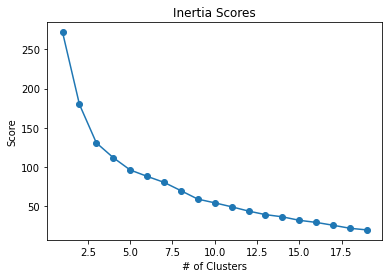

In [330]:
plt.plot(range(1,20), inertia_list, marker = 'o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

In [331]:
silhouette_list = []

for k in range(2,20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))

silhouette_list   

[0.28972838268934986,
 0.32957623647687884,
 0.24452218337444198,
 0.21286938272467767,
 0.20252176058948126,
 0.20089633370873733,
 0.2153805785476277,
 0.23100476428850744,
 0.2377189653813046,
 0.23500470129963946,
 0.23614140162419944,
 0.22288758014616375,
 0.2086136399665321,
 0.222631709548209,
 0.18971649015645142,
 0.20134738932103496,
 0.209122485274174,
 0.17640478578165153]

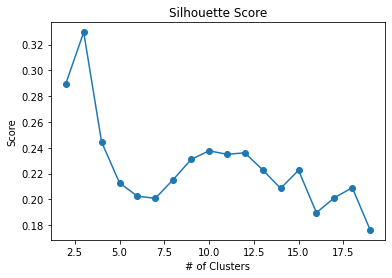

In [332]:
plt.plot(range(2,20), silhouette_list, marker = 'o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Score');

---
#### **Building a Model Using Surprise**

In [34]:
trial_model_df.columns[1:]

Index(['winter_avg_temp', 'summer_avg_temp', 'chain_ratio', 'walkability_idx',
       'political_left_lean', 'political_right_lean', 'miscellaneous_cost_idx',
       'avg_monthly_price'],
      dtype='object')

In [83]:
user_input_3 = ['User Input_3', 65, 75, 14.574597479537353, 0.2, 0.85, 0.15, 135, 5500]

trial_model_df.loc[len(trial_model_df)] = user_input_3

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/565406729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_model_df.loc[len(trial_model_df)] = user_input_3


In [195]:
trial_model_df

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,4312.603960
1,"Austin, TX",53.4,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,6308.753191
2,"Boston, MA",33.1,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,5555.390144
3,"Cambridge, MA",31.1,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5296.311131
5,"Columbus, OH",32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3873.294872
6,"Dallas, TX",49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,3967.300242
7,"Denver, CO",33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4264.297859
8,"Fort Lauderdale, FL",70.3,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5109.527675
9,"Fort Worth, TX",49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,3965.832342


In [196]:
feature_cols = trial_model_df.columns[1:]

sc = MinMaxScaler()
scaled_trial = sc.fit_transform(trial_model_df[feature_cols])

print(scaled_trial[:2])


# indices = pd.Series(trial_model_df.index, index=trial_model_df['place'])

# cosine = cosine_similarity(scaled_trial)

# def place_recommender(place_name, model=cosine):
#     index = indices[place_name]

#     scores = list(enumerate(model[index]))

#     sim_scores = sorted(scores, key= lambda x:x[1], reverse=True)
#     sim_scores = sim_scores[1:11]

#     top_recs_index = [i[0] for i in sim_scores]

#     top_places = trial_model_df['place'].iloc[top_recs_index]

#     return top_places


# print('Recommended Places:')
# print(place_recommender('User Input_3', cosine).values)

[[0.36755307 0.32       0.53375196 0.40066191 0.25       0.7597254
  0.21837709 0.1439967 ]
 [0.58683816 0.80533333 0.60058309 0.59520954 0.52083333 0.4805492
  0.15513126 0.47360877]]


In [197]:
pd.DataFrame(scaled_trial)

,0,1,2,3,4,5,6,7
0,0.367553,0.320000,0.533752,0.400662,0.250000,0.759725,0.218377,0.143997
1,0.586838,0.805333,0.600583,0.595210,0.520833,0.480549,0.155131,0.473609
2,0.250454,0.401333,0.372281,0.906983,0.733796,0.276888,0.775656,0.349210
3,0.217312,0.377333,0.480153,0.681086,0.523148,0.478261,1.000000,0.345975
4,0.168153,0.469333,0.578829,0.788372,0.585648,0.425629,0.559666,0.306430
5,0.246587,0.476000,0.869253,0.598889,0.365741,0.640732,0.174224,0.071456
6,0.523317,0.818667,0.817896,0.630117,0.370370,0.638444,0.177804,0.086979
7,0.251558,0.450667,0.479480,0.863727,0.710648,0.292906,0.707637,0.136020
8,0.866882,0.813333,0.605741,0.679922,0.361111,0.670481,0.175418,0.275588
9,0.516689,0.797333,1.000000,0.419249,0.009259,1.000000,0.194511,0.086736


In [198]:
surprise_test_df = pd.DataFrame(scaled_trial)
# surprise_test_df['8'] = 

In [37]:
import os

In [50]:
from surprise import  SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate

In [47]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(surprise_test_df[[1, 2,7]], reader)

In [51]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/90138220.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/90138220.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/90138220.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/901

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.234438,0.000645,0.000269
KNNBaseline,0.247393,0.001537,0.000109
BaselineOnly,0.247453,0.000149,0.000096
KNNWithMeans,0.248007,0.000355,0.000117
KNNBasic,0.248979,0.000115,0.000140
SVD,0.250565,0.001606,0.000295
CoClustering,0.252582,0.004678,0.000107
KNNWithZScore,0.256135,0.001078,0.000131
NMF,0.260636,0.002441,0.000245


In [52]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.1811006 , 0.20391917, 0.34563304]),
 'fit_time': (0.0002219676971435547,
  0.00017499923706054688,
  0.000125885009765625),
 'test_time': (0.0001087188720703125,
  9.417533874511719e-05,
  8.916854858398438e-05)}

In [53]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.2669  0.2019  0.2905  0.1683  0.1616  0.3553  0.4137  0.2192  0.0983  0.1348  0.2311  0.0950  
MAE (testset)     0.2495  0.1628  0.2581  0.1678  0.1551  0.2681  0.3269  0.1603  0.0958  0.1041  0.1948  0.0724  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [62]:
from surprise.model_selection import GridSearchCV, train_test_split

In [56]:
param_grid = {
  'n_factors': [20, 50, 100],
  'n_epochs': [5, 10, 20]
}
 
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)
 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.23268559450881066
{'n_factors': 50, 'n_epochs': 20}


In [59]:
svd_test = SVD(random_state=42)

svd_test.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [60]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(surprise_test_df[[1, 2,7]], reader)

In [63]:
train, test = train_test_split(data, test_size=.2, random_state=42)

In [64]:
svd_test = SVD(random_state=42)

In [65]:
svd_test.fit(train)

In [66]:
svd_test.test(test)

[Prediction(uid=0.8186666666666667, iid=0.8178963893249609, r_ui=0.0869787759907108, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.7519999999999998, iid=0.36084323839425886, r_ui=0.43742878261203766, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.6053333333333328, iid=0.391567616057412, r_ui=0.13408899622178294, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.4506666666666659, iid=0.47947970396949996, r_ui=0.13602020033692697, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.5865333333333331, iid=0.08970621215519176, r_ui=0.5177323898046701, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.586666666666666, iid=0.576810944157883, r_ui=0.49828469874381953, est=0.3671362373283437, details={'was_impossible': False}),
 Prediction(uid=0.34666666666666623, iid=0.620766988113927, r_ui=0.27058595160066634, est=0.3671362373283437, details={'was_im

In [199]:
trial_model_df

,place,winter_avg_temp,summer_avg_temp,chain_ratio,walkability_idx,political_left_lean,political_right_lean,miscellaneous_cost_idx,avg_monthly_price
0,"Asheville, NC",40.166667,70.200000,0.351600,9.382035,0.5970,0.3860,111.200000,4312.603960
1,"Austin, TX",53.4,82.333333,0.381400,11.516379,0.7140,0.2640,105.900000,6308.753191
2,"Boston, MA",33.1,72.233333,0.279600,14.936791,0.8060,0.1750,157.900000,5555.390144
3,"Cambridge, MA",31.1,71.633333,0.327700,12.458517,0.7150,0.2630,176.700000,5535.792952
4,"Chicago, IL",28.133333,73.933333,0.371700,13.635529,0.7420,0.2400,139.800000,5296.311131
5,"Columbus, OH",32.866667,74.100000,0.501200,11.556746,0.6470,0.3340,107.500000,3873.294872
6,"Dallas, TX",49.566667,82.666667,0.478300,11.899341,0.6490,0.3330,107.800000,3967.300242
7,"Denver, CO",33.166667,73.466667,0.327400,14.462231,0.7960,0.1820,152.200000,4264.297859
8,"Fort Lauderdale, FL",70.3,82.533333,0.383700,12.445745,0.6450,0.3470,107.600000,5109.527675
9,"Fort Worth, TX",49.166667,82.133333,0.559500,9.585953,0.4930,0.4910,109.200000,3965.832342


In [200]:
surprise_test_df.columns = ['winter', 'summer', 'chain', 'walk', 'left', 'right', 'misc', 'price']
surprise_test_df['score'] = (surprise_test_df['winter']*1) + (surprise_test_df['summer']*2) + (surprise_test_df['chain']*3) + (surprise_test_df['walk']*4) + (surprise_test_df['left']*5) + (surprise_test_df['right']*6) + (surprise_test_df['misc']*7) + (surprise_test_df['price']*8)
surprise_test_df

,winter,summer,chain,walk,left,right,misc,price,score
0,0.367553,0.320000,0.533752,0.400662,0.250000,0.759725,0.218377,0.143997,12.700422
1,0.586838,0.805333,0.600583,0.595210,0.520833,0.480549,0.155131,0.473609,16.742343
2,0.250454,0.401333,0.372281,0.906983,0.733796,0.276888,0.775656,0.349210,19.351483
3,0.217312,0.377333,0.480153,0.681086,0.523148,0.478261,1.000000,0.345975,20.389884
4,0.168153,0.469333,0.578829,0.788372,0.585648,0.425629,0.559666,0.306430,17.847916
5,0.246587,0.476000,0.869253,0.598889,0.365741,0.640732,0.174224,0.071456,13.666220
6,0.523317,0.818667,0.817896,0.630117,0.370370,0.638444,0.177804,0.086979,14.757783
7,0.251558,0.450667,0.479480,0.863727,0.710648,0.292906,0.707637,0.136020,17.398538
8,0.866882,0.813333,0.605741,0.679922,0.361111,0.670481,0.175418,0.275588,16.291527
9,0.516689,0.797333,1.000000,0.419249,0.009259,1.000000,0.194511,0.086736,14.890115


In [201]:
min_score = surprise_test_df['score'].min()
max_score = surprise_test_df['score'].max()

In [202]:
surprise_test_df['place_id'] = list(surprise_test_df.index)
surprise_test_df['user_id'] = list(trial_model_df['place'])

In [203]:
surprise_test_df

,winter,summer,chain,walk,left,right,misc,price,score,place_id,user_id
0,0.367553,0.320000,0.533752,0.400662,0.250000,0.759725,0.218377,0.143997,12.700422,0,"Asheville, NC"
1,0.586838,0.805333,0.600583,0.595210,0.520833,0.480549,0.155131,0.473609,16.742343,1,"Austin, TX"
2,0.250454,0.401333,0.372281,0.906983,0.733796,0.276888,0.775656,0.349210,19.351483,2,"Boston, MA"
3,0.217312,0.377333,0.480153,0.681086,0.523148,0.478261,1.000000,0.345975,20.389884,3,"Cambridge, MA"
4,0.168153,0.469333,0.578829,0.788372,0.585648,0.425629,0.559666,0.306430,17.847916,4,"Chicago, IL"
5,0.246587,0.476000,0.869253,0.598889,0.365741,0.640732,0.174224,0.071456,13.666220,5,"Columbus, OH"
6,0.523317,0.818667,0.817896,0.630117,0.370370,0.638444,0.177804,0.086979,14.757783,6,"Dallas, TX"
7,0.251558,0.450667,0.479480,0.863727,0.710648,0.292906,0.707637,0.136020,17.398538,7,"Denver, CO"
8,0.866882,0.813333,0.605741,0.679922,0.361111,0.670481,0.175418,0.275588,16.291527,8,"Fort Lauderdale, FL"
9,0.516689,0.797333,1.000000,0.419249,0.009259,1.000000,0.194511,0.086736,14.890115,9,"Fort Worth, TX"


In [204]:
reader = Reader(rating_scale=(min_score, max_score))
data = Dataset.load_from_df(surprise_test_df[['user_id', 'place_id', 'score']], reader)

In [205]:
svd_new = SVD(n_epochs=10, verbose=True)

svd_scaled_df = data.build_full_trainset()

svd.fit(svd_scaled_df)

In [206]:
svd.predict(uid='User Input', iid=32)

Prediction(uid='User Input', iid=32, r_ui=None, est=17.249209489936973, details={'was_impossible': False})

In [139]:
surprise_test_df['user_id'][1]

'Austin, TX'

In [142]:
svd.get_neighbors(iid=33, k=5)

AttributeError: 'SVD' object has no attribute 'sim'

In [207]:
predictions = pd.DataFrame(columns=['place', 'pred_score'])

for i in surprise_test_df['place_id']:
    place_name = (surprise_test_df['user_id'][svd.predict(uid='User Input_3', iid = i)[1]])
    svd_score = (svd.predict(uid='User Input_3', iid = i)[3])
    predictions.loc[len(predictions)] = [place_name, svd_score]

predictions

,place,pred_score
0,"Asheville, NC",16.774798
1,"Austin, TX",16.963184
2,"Boston, MA",17.081689
3,"Cambridge, MA",17.137635
4,"Chicago, IL",17.029012
5,"Columbus, OH",16.833561
6,"Dallas, TX",16.879075
7,"Denver, CO",16.995639
8,"Fort Lauderdale, FL",16.949619
9,"Fort Worth, TX",16.881552


In [208]:
predictions.sort_values('pred_score')

,place,pred_score
24,"Salem, OR",16.760180
0,"Asheville, NC",16.774798
10,"Hawaii, HI",16.784993
17,"New Orleans, LA",16.805230
5,"Columbus, OH",16.833561
19,"Newark, NJ",16.849541
22,"Portland, OR",16.872750
6,"Dallas, TX",16.879075
9,"Fort Worth, TX",16.881552
11,"Jersey City, NJ",16.909809


In [223]:
user_input_pred_score = predictions.loc[predictions.index[predictions['place'] == 'User Input'][0]]['pred_score']

In [221]:
predictions.index[predictions['place'] == 'User Input'][0]

33

In [227]:
predictions['diff'] = abs(user_input_pred_score - predictions['pred_score'])

predictions

,place,pred_score,diff
0,"Asheville, NC",16.774798,0.317867
1,"Austin, TX",16.963184,0.129481
2,"Boston, MA",17.081689,0.010975
3,"Cambridge, MA",17.137635,0.044971
4,"Chicago, IL",17.029012,0.063652
5,"Columbus, OH",16.833561,0.259104
6,"Dallas, TX",16.879075,0.213589
7,"Denver, CO",16.995639,0.097026
8,"Fort Lauderdale, FL",16.949619,0.143046
9,"Fort Worth, TX",16.881552,0.211113


In [228]:
predictions.sort_values('diff')

,place,pred_score,diff
33,User Input,17.092664,0.000000
14,"Los Angeles, CA",17.092376,0.000288
28,"Santa Clara, CA",17.091165,0.001500
2,"Boston, MA",17.081689,0.010975
23,"Rhode Island, RI",17.104605,0.011941
26,"San Francisco, CA",17.071000,0.021664
31,"Twin Cities, MN",17.069481,0.023183
27,"San Mateo, CA",17.054114,0.038550
32,"Washington, DC",17.049020,0.043645
3,"Cambridge, MA",17.137635,0.044971


In [250]:
surprise_test_df.columns

Index(['winter', 'summer', 'chain', 'walk', 'left', 'right', 'misc', 'price',
       'score', 'place_id', 'user_id'],
      dtype='object')

In [255]:
winter = surprise_test_df[['place_id', 'user_id', 'winter']]
winter['place_id'] = 'winter'
winter.rename(columns={'winter': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

summer = surprise_test_df[['place_id', 'user_id', 'summer']]
summer['place_id'] = 'summer'
summer.rename(columns={'summer': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

chain = surprise_test_df[['place_id', 'user_id', 'chain']]
chain['place_id'] = 'chain'
chain.rename(columns={'chain': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

walk = surprise_test_df[['place_id', 'user_id', 'walk']]
walk['place_id'] = 'walk'
walk.rename(columns={'walk': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

left = surprise_test_df[['place_id', 'user_id', 'left']]
left['place_id'] = 'left'
left.rename(columns={'left': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

right = surprise_test_df[['place_id', 'user_id', 'right']]
right['place_id'] = 'right'
right.rename(columns={'right': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

misc = surprise_test_df[['place_id', 'user_id', 'misc']]
misc['place_id'] = 'misc'
misc.rename(columns={'misc': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

price = surprise_test_df[['place_id', 'user_id', 'price']]
price['place_id'] = 'price'
price.rename(columns={'price': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

score = surprise_test_df[['place_id', 'user_id', 'score']]
score['place_id'] = 'score'
score.rename(columns={'score': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)

new_test_df = pd.concat([winter, summer, chain, walk, left, right, misc, price, score], axis=0)
new_test_df

/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/2063312616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter['place_id'] = 'winter'
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/2063312616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter.rename(columns={'winter': 'scores', 'place_id': 'feat_id', 'user_id': 'place_id'}, inplace=True)
/var/folders/td/_057xlcn5px5szx_85_2v2dc0000gn/T/ipykernel_4736/2063312616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,feat_id,place_id,scores
0,winter,"Asheville, NC",0.367553
1,winter,"Austin, TX",0.586838
2,winter,"Boston, MA",0.250454
3,winter,"Cambridge, MA",0.217312
4,winter,"Chicago, IL",0.168153
...,...,...,...
29,score,"Santa Cruz, CA",21.109935
30,score,"Seattle, WA",16.050544
31,score,"Twin Cities, MN",18.861809
32,score,"Washington, DC",18.540614


In [266]:
new_test_df[['place_id', 'feat_id', 'scores']]

,place_id,feat_id,scores
0,"Asheville, NC",winter,0.367553
1,"Austin, TX",winter,0.586838
2,"Boston, MA",winter,0.250454
3,"Cambridge, MA",winter,0.217312
4,"Chicago, IL",winter,0.168153
...,...,...,...
29,"Santa Cruz, CA",score,21.109935
30,"Seattle, WA",score,16.050544
31,"Twin Cities, MN",score,18.861809
32,"Washington, DC",score,18.540614


In [258]:
new_min_score = new_test_df['scores'].min()
new_max_score = new_test_df['scores'].max()

In [267]:
reader = Reader(rating_scale=(new_min_score, new_max_score))
data = Dataset.load_from_df(new_test_df[['place_id', 'feat_id', 'scores']], reader)

In [260]:
data

In [274]:
new_sim_options = {'name': 'cosine', 'user_based': True}

knn_new = KNNBasic(k=5, sim_options = new_sim_options)

In [275]:
train, test = train_test_split(data, test_size=.2, random_state=42)

In [276]:
# knn_new = KNNBasic()

knn_new.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [277]:
pd.DataFrame(knn_new.test(test))

,uid,iid,r_ui,est,details
0,"Santa Cruz, CA",right,0.299771,0.586716,"{'actual_k': 5, 'was_impossible': False}"
1,"Los Angeles, CA",winter,0.548726,0.345492,"{'actual_k': 5, 'was_impossible': False}"
2,"Las Vegas, NV",summer,1.000000,0.625476,"{'actual_k': 5, 'was_impossible': False}"
3,"San Francisco, CA",chain,0.123570,0.380803,"{'actual_k': 5, 'was_impossible': False}"
4,"Twin Cities, MN",price,0.434719,0.454284,"{'actual_k': 5, 'was_impossible': False}"
...,...,...,...,...,...
57,"New York City, NY",right,0.489703,0.473222,"{'actual_k': 5, 'was_impossible': False}"
58,"Cambridge, MA",chain,0.480153,0.414843,"{'actual_k': 5, 'was_impossible': False}"
59,"Chicago, IL",walk,0.788372,0.755911,"{'actual_k': 5, 'was_impossible': False}"
60,"Washington, DC",price,0.134089,0.267102,"{'actual_k': 5, 'was_impossible': False}"


In [279]:
knn_new.predict(uid='User Input', iid='score')

Prediction(uid='User Input', iid='score', r_ui=None, est=17.889027106156185, details={'actual_k': 5, 'was_impossible': False})

In [300]:
new_knn_predictions = pd.DataFrame(columns=['place', 'pred_score'])

for i in new_test_df['place_id'].unique():
    place_name = i
    knn_score = (knn_new.predict(uid= i, iid = 'score')[3])
    new_knn_predictions.loc[len(new_knn_predictions)] = [place_name, knn_score]

new_knn_predictions

,place,pred_score
0,"Asheville, NC",15.031410
1,"Austin, TX",16.777256
2,"Boston, MA",18.359832
3,"Cambridge, MA",18.862861
4,"Chicago, IL",18.391581
5,"Columbus, OH",16.581803
6,"Dallas, TX",15.408309
7,"Denver, CO",17.874257
8,"Fort Lauderdale, FL",17.583639
9,"Fort Worth, TX",14.877477


In [301]:
new_knn_user_pred_score = knn_new.predict(uid='User Input', iid='score')[3]

new_knn_predictions['diff'] = abs(new_knn_user_pred_score - new_knn_predictions['pred_score'])

new_knn_predictions.sort_values('diff')

,place,pred_score,diff
33,User Input,17.889027,0.000000
7,"Denver, CO",17.874257,0.014770
21,"Oakland, CA",18.059633,0.170606
26,"San Francisco, CA",17.597381,0.291646
8,"Fort Lauderdale, FL",17.583639,0.305388
16,"Nashville, TN",17.500219,0.388808
2,"Boston, MA",18.359832,0.470805
4,"Chicago, IL",18.391581,0.502554
30,"Seattle, WA",18.427823,0.538796
18,"New York City, NY",18.667817,0.778790


In [299]:
knn_new.predict(uid='Boston, MA', iid='score')[3]

18.35983188562387

In [297]:
for i in new_test_df['place_id'].unique():
    print(i)

Asheville, NC
Austin, TX
Boston, MA
Cambridge, MA
Chicago, IL
Columbus, OH
Dallas, TX
Denver, CO
Fort Lauderdale, FL
Fort Worth, TX
Hawaii, HI
Jersey City, NJ
Kauai, HI
Las Vegas, NV
Los Angeles, CA
Maui, HI
Nashville, TN
New Orleans, LA
New York City, NY
Newark, NJ
Oahu, HI
Oakland, CA
Portland, OR
Rhode Island, RI
Salem, OR
San Diego, CA
San Francisco, CA
San Mateo, CA
Santa Clara, CA
Santa Cruz, CA
Seattle, WA
Twin Cities, MN
Washington, DC
User Input


In [296]:
new_test_df['place_id'].unique()

array(['Asheville, NC', 'Austin, TX', 'Boston, MA', 'Cambridge, MA',
       'Chicago, IL', 'Columbus, OH', 'Dallas, TX', 'Denver, CO',
       'Fort Lauderdale, FL', 'Fort Worth, TX', 'Hawaii, HI',
       'Jersey City, NJ', 'Kauai, HI', 'Las Vegas, NV', 'Los Angeles, CA',
       'Maui, HI', 'Nashville, TN', 'New Orleans, LA',
       'New York City, NY', 'Newark, NJ', 'Oahu, HI', 'Oakland, CA',
       'Portland, OR', 'Rhode Island, RI', 'Salem, OR', 'San Diego, CA',
       'San Francisco, CA', 'San Mateo, CA', 'Santa Clara, CA',
       'Santa Cruz, CA', 'Seattle, WA', 'Twin Cities, MN',
       'Washington, DC', 'User Input'], dtype=object)

In [280]:
new_test_df

,feat_id,place_id,scores
0,winter,"Asheville, NC",0.367553
1,winter,"Austin, TX",0.586838
2,winter,"Boston, MA",0.250454
3,winter,"Cambridge, MA",0.217312
4,winter,"Chicago, IL",0.168153
...,...,...,...
29,score,"Santa Cruz, CA",21.109935
30,score,"Seattle, WA",16.050544
31,score,"Twin Cities, MN",18.861809
32,score,"Washington, DC",18.540614


In [ ]:
new_knn_predictions = pd.DataFrame(columns=['place', 'pred_score'])

for i in surprise_test_df['place_id']:
    place_name = (surprise_test_df['user_id'][svd.predict(uid='User Input', iid = i)[1]])
    svd_score = (svd.predict(uid='User Input_3', iid = i)[3])
    predictions.loc[len(predictions)] = [place_name, svd_score]

predictions

In [278]:
pd.DataFrame(knn_new.compute_similarities())

Computing the cosine similarity matrix...
Done computing similarity matrix.


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.000000,0.996976,0.997564,0.762908,0.995426,0.996541,0.383027,0.997484,0.998160,0.996783,...,0.996191,0.998980,0.998791,0.997158,0.995493,0.997526,0.994961,0.526638,0.998951,0.996281
1,0.996976,1.000000,0.998209,0.927180,0.999768,0.998637,0.972923,0.999726,0.998707,0.999779,...,0.999054,0.999865,0.999745,0.999685,0.999919,0.998826,0.999857,0.988168,0.999706,0.999597
2,0.997564,0.998209,1.000000,0.725908,0.997536,0.998057,0.703286,0.999393,0.999532,0.997912,...,0.999510,0.998296,0.999895,0.998149,0.996636,0.999545,0.997534,0.473693,0.998506,0.997225
3,0.762908,0.927180,0.725908,1.000000,0.855999,0.833065,0.937553,0.726430,0.759564,0.877073,...,0.750305,0.930736,0.989811,0.920289,0.898630,0.812746,0.871090,0.835280,0.946522,0.916840
4,0.995426,0.999768,0.997536,0.855999,1.000000,0.997036,0.966953,0.998955,0.997961,0.998640,...,0.997010,0.999459,0.999537,0.999627,0.999605,0.997145,0.999796,0.893430,0.998427,0.999544
5,0.996541,0.998637,0.998057,0.833065,0.997036,1.000000,0.809316,0.997147,0.997390,0.998859,...,0.999100,0.998941,0.999439,0.996698,0.997565,0.998350,0.996882,0.795649,0.998898,0.996344
6,0.383027,0.972923,0.703286,0.937553,0.966953,0.809316,1.000000,0.979080,0.808658,0.902238,...,0.822376,0.969803,0.863240,0.885783,0.985505,0.783333,0.967365,0.983759,0.868385,0.914740
7,0.997484,0.999726,0.999393,0.726430,0.998955,0.997147,0.979080,1.000000,0.999698,0.999404,...,0.999433,0.999962,0.999614,0.999526,0.999739,0.998800,0.999523,0.944459,0.999680,0.999312
8,0.998160,0.998707,0.999532,0.759564,0.997961,0.997390,0.808658,0.999698,1.000000,0.999019,...,0.999340,0.999121,0.999809,0.998270,0.997952,0.999598,0.998076,0.621828,0.999326,0.997557
9,0.996783,0.999779,0.997912,0.877073,0.998640,0.998859,0.902238,0.999404,0.999019,1.000000,...,0.998385,0.999779,0.999939,0.998880,0.999366,0.998953,0.998940,0.813263,0.999611,0.998457


In [291]:
knn_sim_scores = pd.concat([pd.Series(new_test_df['place_id'].unique()), pd.DataFrame(knn_new.compute_similarities())[33]], axis=1)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [290]:
new_test_df['place_id'].unique()

array(['Asheville, NC', 'Austin, TX', 'Boston, MA', 'Cambridge, MA',
       'Chicago, IL', 'Columbus, OH', 'Dallas, TX', 'Denver, CO',
       'Fort Lauderdale, FL', 'Fort Worth, TX', 'Hawaii, HI',
       'Jersey City, NJ', 'Kauai, HI', 'Las Vegas, NV', 'Los Angeles, CA',
       'Maui, HI', 'Nashville, TN', 'New Orleans, LA',
       'New York City, NY', 'Newark, NJ', 'Oahu, HI', 'Oakland, CA',
       'Portland, OR', 'Rhode Island, RI', 'Salem, OR', 'San Diego, CA',
       'San Francisco, CA', 'San Mateo, CA', 'Santa Clara, CA',
       'Santa Cruz, CA', 'Seattle, WA', 'Twin Cities, MN',
       'Washington, DC', 'User Input'], dtype=object)

In [294]:
knn_sim_scores.sort_values(by=33, ascending=False)

,0,33
33,User Input,1.000000
27,"San Mateo, CA",0.999864
19,"Newark, NJ",0.999631
30,"Seattle, WA",0.999624
25,"San Diego, CA",0.999615
1,"Austin, TX",0.999597
4,"Chicago, IL",0.999544
18,"New York City, NY",0.999510
13,"Las Vegas, NV",0.999497
26,"San Francisco, CA",0.999482


In [286]:
list(pd.DataFrame(knn_new.compute_similarities())[33])

Computing the cosine similarity matrix...
Done computing similarity matrix.


[0.9962805271199319,
 0.9995973363581151,
 0.9972249306234245,
 0.9168401507332753,
 0.9995444077958653,
 0.9963442386521196,
 0.9147397711960765,
 0.9993118405532624,
 0.9975574457881058,
 0.9984566954901538,
 0.8846810292749197,
 0.998732604180189,
 0.9991038466508344,
 0.9994974909345964,
 0.9992504254912287,
 0.9530470949629782,
 0.998405087787975,
 0.9973734315885083,
 0.9995098143619787,
 0.999631231237828,
 0.8763283811697492,
 0.9979066085572934,
 0.9974634347373056,
 0.9989608398128155,
 0.9967275826853212,
 0.9996149083119102,
 0.9994817516854937,
 0.9998641225253049,
 0.9994240505491617,
 0.996923482419694,
 0.9996240652935865,
 0.8761844123758548,
 0.998787706475028,
 1.0]

In [283]:
new_test_df

,feat_id,place_id,scores
0,winter,"Asheville, NC",0.367553
1,winter,"Austin, TX",0.586838
2,winter,"Boston, MA",0.250454
3,winter,"Cambridge, MA",0.217312
4,winter,"Chicago, IL",0.168153
...,...,...,...
29,score,"Santa Cruz, CA",21.109935
30,score,"Seattle, WA",16.050544
31,score,"Twin Cities, MN",18.861809
32,score,"Washington, DC",18.540614


In [238]:
sim_ops = {'name': 'cosine', 'user_based': True, 'shrinkage': 10000}

model = KNNBasic(sim_options = sim_ops)

In [241]:
model.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [242]:
model.sim

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [132]:
model.compute_similarities()

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])